In [ ]:
!pip install sktime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.9/21.9 MB 34.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.8/128.8 kB 15.9 MB/s eta 0:00:00


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import os

%load_ext autoreload
%autoreload 2

# Contest Data

## import data

In [ ]:
data_path = '/content/data/'

X_validation_df = pd.read_csv(os.path.join(data_path, 'public_data_x.csv'))
y_validation_df = pd.read_csv(os.path.join(data_path, 'public_data_y.csv'))
X_test_df = pd.read_csv(os.path.join(data_path, 'private_data_x.csv'))
y_test_df = pd.read_csv(os.path.join(data_path, 'private_data_y.csv'))
train_all_df = pd.read_csv(os.path.join(data_path, 'train_all.csv'))

## Preprocess training data

in the preprocessed data, we have sliding windows of length 360 (meaning 180 seconds, having two samples per second).

**Num_Window** incidates the number of sliding window, each contains 360 samples (2 samples per second).

**Time** is the field for indicating the sample time

**Room_Num** doesnt change anything, we just need to know which samples belong to which window. (this is also the reason why this field is not present in the validation and test data)

**Device_ID** is used to group all self-related samples so we can analyse them as as a collection of RSS values.

**RSSI_Right** the value of the right RSS antenna

**RSSI_Left** the value of the left RSS antenna

**Num_People** the number of people occupying the room at the time of the sample was taken

**is_occupied (new field to predict)** is the field indicating whether there are people in the room or not, therefore this is our label. (it is a binary label derived from the *Num_People* value




In [ ]:
train_all_df["is_occupied"] = train_all_df.Num_People.apply(lambda count: 1 if count > 0 else 0)

In [ ]:
from tqdm import tqdm

columns = list(train_all_df.columns) + ['Num_Window']
window_size = 360
stride = 45
devices = train_all_df.groupby('Device_ID', sort=False)
Num_Window = 0
train_data_list = []

for device, device_df in tqdm(devices):
    idx = device_df.index
    for i in range(0, idx.shape[0], stride):
        if idx.shape[0] - 1 < i + window_size:
            continue
        window_idx = idx[i:i + window_size]
        if train_all_df.loc[window_idx, 'Num_People'].nunique() == 1:
            window_temp = train_all_df.loc[window_idx].copy()
            window_temp['Num_Window'] = Num_Window
            train_data_list += (window_temp.values.tolist())
            Num_Window += 1

train_data_stride = pd.DataFrame(data=train_data_list, columns=columns)

100%|██████████| 84/84 [01:40<00:00,  1.20s/it]


In [ ]:
windows = train_data_stride.groupby("Num_Window")

In [ ]:
right_rssi_values = []
left_rssi_values = []
wifi_y_train = []

for window, window_df in tqdm(windows):
    right_rssi_values.append(window_df.RSSI_Right.reset_index(drop=True))
    left_rssi_values.append(window_df.RSSI_Left.reset_index(drop=True))
    wifi_y_train.append(window_df.is_occupied.iloc[0])

100%|██████████| 50360/50360 [00:14<00:00, 3454.94it/s]


In [ ]:
left_rssi_series_df = pd.DataFrame({'left_rss_values': left_rssi_values})
right_rssi_series_df = pd.DataFrame({'right_rss_values': right_rssi_values})

## Preprocess validation & test data

In [ ]:
def preprocess_wifi(wifi_df):
    slide_windows = wifi_df.groupby("Num_Window")

    right_rssi_values = []
    left_rssi_values = []
    occupation_label = []  #this is shared among both left&right rssi values

    for window, window_df in tqdm(slide_windows):
        right_rssi_values.append(window_df.RSSI_Right.reset_index(drop=True))
        left_rssi_values.append(window_df.RSSI_Left.reset_index(drop=True))
        occupation_label.append(window_df.is_occupied.iloc[0])

    return right_rssi_values, left_rssi_values, np.array(occupation_label)

preprocess validation data:

In [ ]:
wifi_validation_df = X_validation_df.join(y_validation_df.set_index('Num_Window'), on='Num_Window')

In [ ]:
wifi_validation_df["is_occupied"] = wifi_validation_df.Num_People.apply(lambda count: 1 if count > 0 else 0)

In [ ]:
validation_right_rssi_values, validation_left_rssi_values, validation_labels = preprocess_wifi(wifi_validation_df)

100%|██████████| 246/246 [00:00<00:00, 3509.78it/s]


In [ ]:
validation_left_rssi_series_df = pd.DataFrame({'left_rss_values': validation_left_rssi_values})
validation_right_rssi_series_df = pd.DataFrame({'right_rss_values': validation_right_rssi_values})

and now preprocess test data:

In [ ]:
wifi_test_df = X_test_df.join(y_test_df.set_index('Num_Window'), on='Num_Window')

In [ ]:
wifi_test_df["is_occupied"] = wifi_test_df.Num_People.apply(lambda count: 1 if count > 0 else 0)

In [ ]:
test_right_rssi_values, test_left_rssi_values, test_labels = preprocess_wifi(wifi_test_df)

100%|██████████| 1288/1288 [00:00<00:00, 3405.82it/s]


In [ ]:
test_left_rssi_series_df = pd.DataFrame({'left_rss_values': test_left_rssi_values})
test_right_rssi_series_df = pd.DataFrame({'right_rss_values': test_right_rssi_values})

## check data ratio

In [ ]:
import matplotlib.pyplot as plt


def hist_from_np_array(arr, title: str):
    rng = np.random.RandomState(10)  # deterministic random data
    _ = plt.hist(arr, bins='auto')  # arguments are passed to np.histogram
    plt.title(title)
    plt.show()

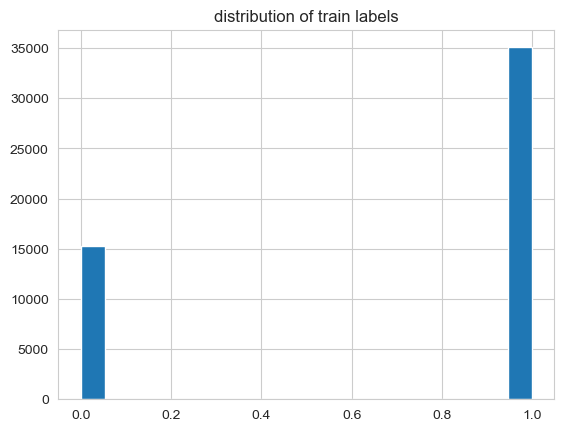

In [ ]:
hist_from_np_array(wifi_y_train, "distribution of train labels")

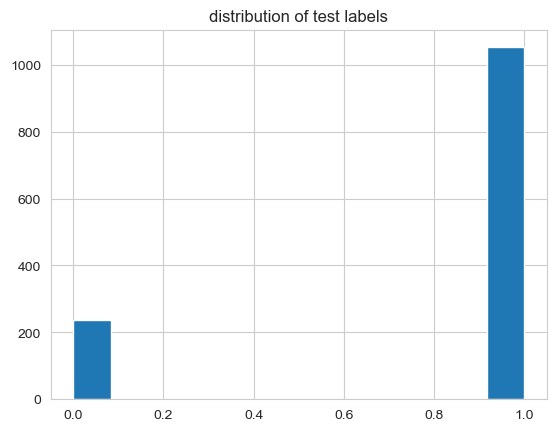

In [ ]:
hist_from_np_array(test_labels, "distribution of test labels")

## Ablation Study

In [ ]:
wifi_y_train = np.array(wifi_y_train)

In [ ]:
from sklearn import metrics


def compute_auc_score(y_test: np.array, y_pred: np.array):
    return metrics.roc_auc_score(y_test, y_pred)


def compute_accuracy_score(y_test: np.array, y_pred: np.array):
    return metrics.accuracy_score(y_test, y_pred)


def generate_precision_recall_curve(y_test: np.array, y_pred: np.array, title: str):
    precision, recall, _ = metrics.precision_recall_curve(y_test, y_pred)
    disp = metrics.PrecisionRecallDisplay(precision=precision, recall=recall)
    disp.plot(name=title)
    plt.show()


def compute_ap(y_test: np.array, y_scores: np.array):
    return metrics.average_precision_score(y_test, y_scores)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import skew, kurtosis
from baseline_functions import BaselineModel
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_recall_curve, precision_score, recall_score, auc
import math
from sktime.classification.kernel_based import RocketClassifier

"""
  this one assumes that the model implements its training and inference via
  "fit" and "predict" methods respectively.
  In addition, in the current implementation we evaluate roc_auc score,
  as our problem is dealing with imbalanced data.
"""


def train_rocket_with_stratified_kfold(data: pd.DataFrame,
                                       labels: np.array,
                                       n_splits=10,
                                       num_kernels=100,
                                       rocket_transform="rocket",
                                       use_multivariate="yes",
                                       use_baseline_model=False):
    skf = StratifiedKFold(n_splits=n_splits)

    precisions = []
    recalls = []
    plot_args = []
    if use_baseline_model:
        precisions_b = []
        recalls_b = []
        plot_args_b = []

    for fold, (train_index, test_index) in enumerate(skf.split(data, labels)):
        X_train, X_test = data.iloc[train_index], data.iloc[test_index]
        y_train, y_test = labels[train_index], labels[test_index]

        # Train your model on the training set
        if use_baseline_model:
            aggregations = [np.std, np.median, np.var, skew, kurtosis]
            baseline_model = BaselineModel(anomaly_threshold=None, model=RandomForestClassifier(),
                                           aggregations=aggregations)
        model = RocketClassifier(num_kernels=num_kernels, rocket_transform=rocket_transform,
                                 use_multivariate=use_multivariate)
        print(f"starts training with fold #{fold + 1}")
        model.fit(X_train, y_train)
        if use_baseline_model:
            baseline_model.fit(X_train, y_train, sample_weight='balanced')

        # Make predictions on the test set
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        if use_baseline_model:
            y_pred_proba_baseline = baseline_model.predict_proba(X_test)[:, 1]

        # Compute precision and recall
        precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
        if use_baseline_model:
            precision_b, recall_b, _ = precision_recall_curve(y_test, y_pred_proba_baseline)

        # Compute area under the curve (AUC) for precision-recall curve
        pr_auc = auc(recall, precision)
        if use_baseline_model:
            pr_auc_b = auc(recall_b, precision_b)

        # save precision-recall curve for each fold
        plot_args.append(dict(x=recall, y=precision, label=f'Fold #{fold + 1} (AUC = {pr_auc:.2f})'))
        if use_baseline_model:
            plot_args_b.append(dict(x=recall_b, y=precision_b, label=f'Fold #{fold + 1} (AUC = {pr_auc_b:.2f})'))

        # Store precision and recall values for mean calculation
        precisions.append(precision)
        recalls.append(recall)
        if use_baseline_model:
            precisions_b.append(precision_b)
            recalls_b.append(recall_b)
        print(f"finished evaluation with fold #{fold + 1}")

    # Plot the mean precision-recall curve
    plt.figure(figsize=(8, 6))
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend(loc='lower left')
    plt.grid(True)
    plt.title('Precision-Recall Curve for 10-Fold Cross Validation for ROCKET Model')
    for args in plot_args:
        plt.plot(args['x'], args['y'], label=args['label'])
    plt.show()
    if use_baseline_model:
        plt.figure(figsize=(8, 6))
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.legend(loc='lower left')
        plt.grid(True)
        plt.title('Precision-Recall Curve for 10-Fold Cross Validation for Baseline Model')
        for args in plot_args_b:
            plt.plot(args['x'], args['y'], label=args['label'])
        plt.show()

    ap = []
    ap_b = []
    for i in range(n_splits):
        ap.append(auc(recalls[i], precisions[i]))
        if use_baseline_model:
            ap_b.append(auc(recalls_b[i], precisions_b[i]))

    if use_baseline_model:
        return np.mean(ap), np.std(ap), np.mean(ap_b), np.std(ap_b)
    return np.mean(ap), np.std(ap)

In [ ]:
def lab_trial(num_kernels: int,
              rocket_transform: str,  # "rocket" / "minirocket"
              use_multivariate: str,  # "yes" / "no"
              training_data_df: pd.DataFrame,
              training_labels: list,
              use_baseline_model=False):
    if use_baseline_model:
        mean_ap, std_ap, mean_ap_b, std_ap_b = train_rocket_with_stratified_kfold(data=training_data_df,
                                                                                  labels=training_labels,
                                                                                  n_splits=10,
                                                                                  num_kernels=num_kernels,
                                                                                  rocket_transform=rocket_transform,
                                                                                  use_multivariate=use_multivariate,
                                                                                  use_baseline_model=use_baseline_model)
        return mean_ap, std_ap, mean_ap_b, std_ap_b
    else:
        mean_ap, std_ap = train_rocket_with_stratified_kfold(data=training_data_df,
                                                             labels=training_labels,
                                                             n_splits=10,
                                                             num_kernels=num_kernels,
                                                             rocket_transform=rocket_transform,
                                                             use_multivariate=use_multivariate,
                                                             use_baseline_model=use_baseline_model)

        return mean_ap, std_ap

### Single antenna vs both antennas

#### Single antenna

starts training with fold #1


C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core\algorithms.py:1814: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core\algorithms.py:1814: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core\algorithms.py:1814: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core

finished evaluation with fold #1
starts training with fold #2


C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core\algorithms.py:1814: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core\algorithms.py:1814: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core\algorithms.py:1814: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core

finished evaluation with fold #2
starts training with fold #3


C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core\algorithms.py:1814: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core\algorithms.py:1814: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core\algorithms.py:1814: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core

finished evaluation with fold #3
starts training with fold #4


C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core\algorithms.py:1814: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core\algorithms.py:1814: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core\algorithms.py:1814: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core

finished evaluation with fold #4
starts training with fold #5


C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core\algorithms.py:1814: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core\algorithms.py:1814: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core\algorithms.py:1814: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core

finished evaluation with fold #5
starts training with fold #6


C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core\algorithms.py:1814: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core\algorithms.py:1814: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core\algorithms.py:1814: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core

finished evaluation with fold #6
starts training with fold #7


C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core\algorithms.py:1814: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core\algorithms.py:1814: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core\algorithms.py:1814: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core

finished evaluation with fold #7
starts training with fold #8


C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core\algorithms.py:1814: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core\algorithms.py:1814: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core\algorithms.py:1814: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core

finished evaluation with fold #8
starts training with fold #9


C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core\algorithms.py:1814: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core\algorithms.py:1814: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core\algorithms.py:1814: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core

finished evaluation with fold #9
starts training with fold #10


C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core\algorithms.py:1814: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core\algorithms.py:1814: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core\algorithms.py:1814: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core

finished evaluation with fold #10


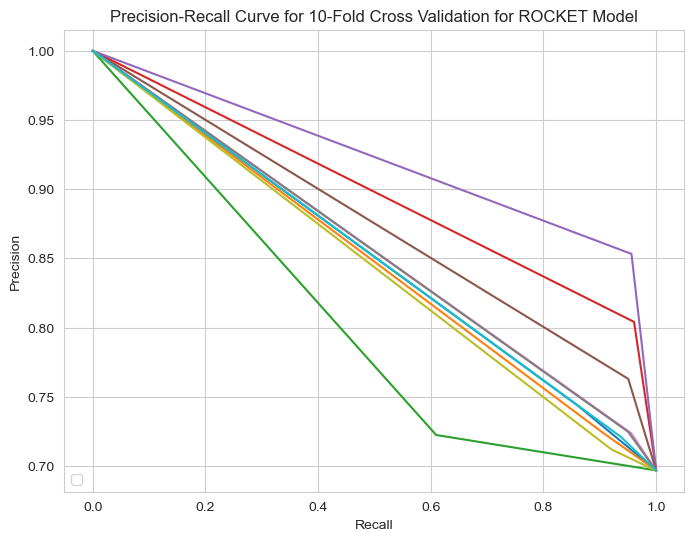

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


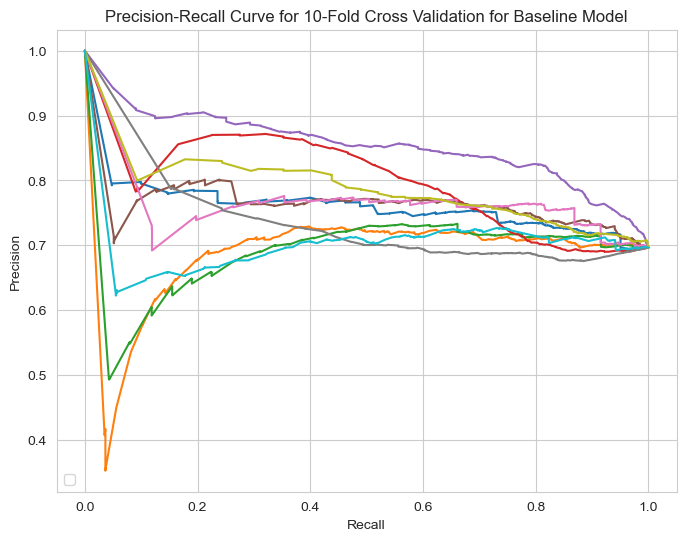

Rocket Model: Mean AP: 0.86, Standard Deviation: 0.03
Baseline Model: Mean AP: 0.76, Standard Deviation: 0.05


In [ ]:
mean_ap, std_ap, mean_ap_b, std_ap_b = lab_trial(num_kernels=50, rocket_transform="rocket", use_multivariate="no",
                                                 training_data_df=right_rssi_series_df,
                                                 training_labels=wifi_y_train, use_baseline_model=True)
print('Rocket Model: Mean AP: %.2f, Standard Deviation: %.2f' % (mean_ap, std_ap))
print('Baseline Model: Mean AP: %.2f, Standard Deviation: %.2f' % (mean_ap_b, std_ap_b))

#### Both antennas values

In [ ]:
# This is the combined dataset training df which is going to be used for the rest of the studies
combined_rss_training_df = pd.concat([right_rssi_series_df, left_rssi_series_df], axis=1)
combined_rss_training_df

,right_rss_values,left_rss_values
0,0 -51.0 1 -51.0 2 -51.0 3 -51....,0 -42.0 1 -42.0 2 -42.0 3 -42....
1,0 -51.0 1 -51.0 2 -51.0 3 -51....,0 -42.0 1 -42.0 2 -42.0 3 -42....
2,0 -51.0 1 -51.0 2 -51.0 3 -51....,0 -42.0 1 -42.0 2 -42.0 3 -42....
3,0 -42.0 1 -42.0 2 -42.0 3 -42....,0 -52.0 1 -52.0 2 -52.0 3 -52....
4,0 -42.0 1 -42.0 2 -42.0 3 -42....,0 -52.0 1 -52.0 2 -52.0 3 -52....
...,...,...
50355,0 -49.0 1 -49.0 2 -49.0 3 -49....,0 -51.0 1 -51.0 2 -51.0 3 -51....
50356,0 -49.0 1 -49.0 2 -49.0 3 -49....,0 -51.0 1 -51.0 2 -51.0 3 -51....
50357,0 -49.0 1 -49.0 2 -49.0 3 -49....,0 -51.0 1 -51.0 2 -51.0 3 -51....
50358,0 -49.0 1 -49.0 2 -49.0 3 -49....,0 -51.0 1 -51.0 2 -51.0 3 -51....


starts training with fold #1


C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core\algorithms.py:1814: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core\algorithms.py:1814: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core\algorithms.py:1814: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core

finished evaluation with fold #1
starts training with fold #2


C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core\algorithms.py:1814: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core\algorithms.py:1814: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core\algorithms.py:1814: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core

finished evaluation with fold #2
starts training with fold #3


C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core\algorithms.py:1814: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core\algorithms.py:1814: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core\algorithms.py:1814: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core

finished evaluation with fold #3
starts training with fold #4


C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core\algorithms.py:1814: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core\algorithms.py:1814: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core\algorithms.py:1814: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core

finished evaluation with fold #4
starts training with fold #5


C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core\algorithms.py:1814: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core\algorithms.py:1814: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core\algorithms.py:1814: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core

finished evaluation with fold #5
starts training with fold #6


C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core\algorithms.py:1814: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core\algorithms.py:1814: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core\algorithms.py:1814: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core

finished evaluation with fold #6
starts training with fold #7


C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core\algorithms.py:1814: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core\algorithms.py:1814: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core\algorithms.py:1814: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core

finished evaluation with fold #7
starts training with fold #8


C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core\algorithms.py:1814: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core\algorithms.py:1814: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core\algorithms.py:1814: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core

finished evaluation with fold #8
starts training with fold #9


C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core\algorithms.py:1814: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core\algorithms.py:1814: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core\algorithms.py:1814: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core

finished evaluation with fold #9
starts training with fold #10


C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core\algorithms.py:1814: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core\algorithms.py:1814: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core\algorithms.py:1814: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core

finished evaluation with fold #10


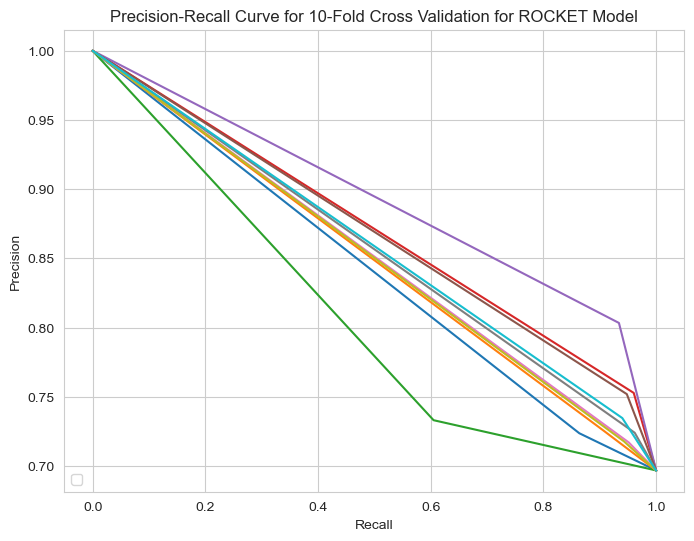

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


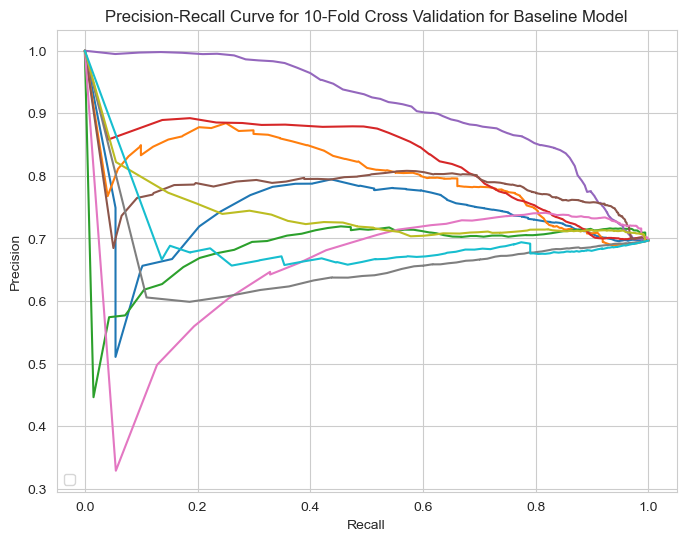

Rocket Model: Mean AP: 0.85, Standard Deviation: 0.02
Baseline Model: Mean AP: 0.75, Standard Deviation: 0.08


In [ ]:
mean_ap, std_ap, mean_ap_b, std_ap_b = lab_trial(num_kernels=50, rocket_transform="rocket", use_multivariate="yes", training_data_df=combined_rss_training_df,
          training_labels=wifi_y_train, use_baseline_model=True)
print('Rocket Model: Mean AP: %.2f, Standard Deviation: %.2f' % (mean_ap, std_ap))
print('Baseline Model: Mean AP: %.2f, Standard Deviation: %.2f' % (mean_ap_b, std_ap_b))

In [ ]:
# This is the combined dataset testing df which is going to be used for the rest of the studies
combined_rss_test_df = pd.concat([test_right_rssi_series_df, test_left_rssi_series_df], axis=1)
combined_rss_test_df

,right_rss_values,left_rss_values
0,0 -54 1 -54 2 -54 3 -54 4 ...,0 -45 1 -45 2 -45 3 -45 4 ...
1,0 -56 1 -56 2 -56 3 -56 4 ...,0 -45 1 -45 2 -45 3 -45 4 ...
2,0 -46 1 -46 2 -55 3 -55 4 ...,0 -36 1 -36 2 -45 3 -45 4 ...
3,0 -53 1 -53 2 -55 3 -55 4 ...,0 -45 1 -45 2 -45 3 -45 4 ...
4,0 -48 1 -56 2 -56 3 -56 4 ...,0 -38 1 -45 2 -45 3 -45 4 ...
...,...,...
1283,0 -37 1 -37 2 -37 3 -37 4 ...,0 -46 1 -46 2 -46 3 -46 4 ...
1284,0 -36 1 -36 2 -36 3 -36 4 ...,0 -45 1 -45 2 -45 3 -45 4 ...
1285,0 -36 1 -36 2 -36 3 -36 4 ...,0 -45 1 -45 2 -45 3 -45 4 ...
1286,0 -36 1 -36 2 -36 3 -36 4 ...,0 -52 1 -52 2 -52 3 -52 4 ...


#### conclusion
We can see that using a single antenna yields close-to-same results as the model using both antennas' data, so it might point to a strong correlation between both antennas' signals, but as we can't be sure about it - in all the ablation studies to follow we are going to use data from both antennas.

### Training with different amount of data
This is the crucial part, as we might observe that training with larger data doensn't necessarily help with getting better results, thus allowing us to train larger models with less data to reduce training time.

In this section, all studies are going to be tested with a 1K multivariate kernel Rocket.

Note that we should keep the positive-negative label ratio of 2:1 from the whole dataset among different portions of data so the results won't be biased.

#### 25% data

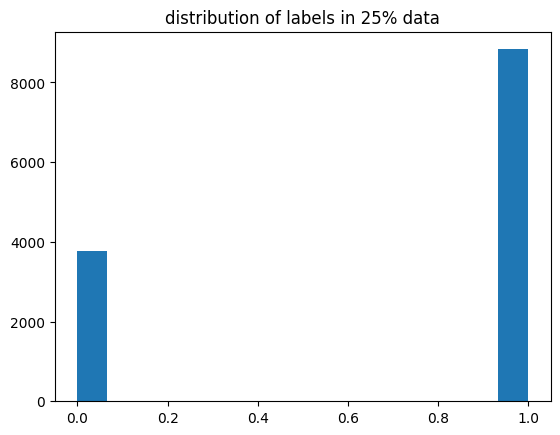

In [ ]:
wifi_first_25p_data = combined_rss_training_df[:len(wifi_y_train) // 4]
wifi_first_25p_labels = wifi_y_train[:len(wifi_y_train) // 4]

hist_from_np_array(wifi_first_25p_labels, "distribution of labels in 25% data")

we see that the ratio is nearly kept so we can move on and train Rocket for this one.

starts training with fold #1


C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core\algorithms.py:1814: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core\algorithms.py:1814: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core\algorithms.py:1814: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core

finished evaluation with fold #1
starts training with fold #2


C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core\algorithms.py:1814: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core\algorithms.py:1814: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core\algorithms.py:1814: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core

finished evaluation with fold #2
starts training with fold #3


C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core\algorithms.py:1814: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core\algorithms.py:1814: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core\algorithms.py:1814: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core

finished evaluation with fold #3
starts training with fold #4


C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core\algorithms.py:1814: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core\algorithms.py:1814: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core\algorithms.py:1814: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core

finished evaluation with fold #4
starts training with fold #5


C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core\algorithms.py:1814: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core\algorithms.py:1814: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core\algorithms.py:1814: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core

finished evaluation with fold #5
starts training with fold #6


C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core\algorithms.py:1814: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core\algorithms.py:1814: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core\algorithms.py:1814: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core

finished evaluation with fold #6
starts training with fold #7


C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core\algorithms.py:1814: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core\algorithms.py:1814: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core\algorithms.py:1814: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core

finished evaluation with fold #7
starts training with fold #8


C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core\algorithms.py:1814: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core\algorithms.py:1814: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core\algorithms.py:1814: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core

finished evaluation with fold #8
starts training with fold #9


C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core\algorithms.py:1814: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core\algorithms.py:1814: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core\algorithms.py:1814: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core

finished evaluation with fold #9
starts training with fold #10


C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core\algorithms.py:1814: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core\algorithms.py:1814: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core\algorithms.py:1814: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core

finished evaluation with fold #10


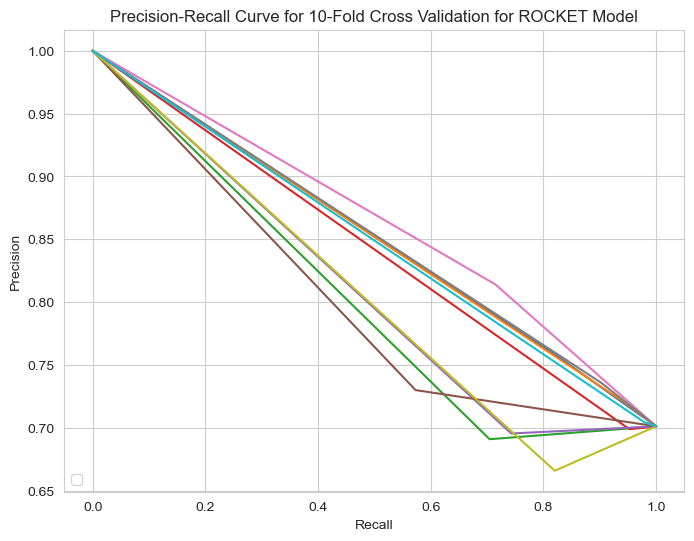

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


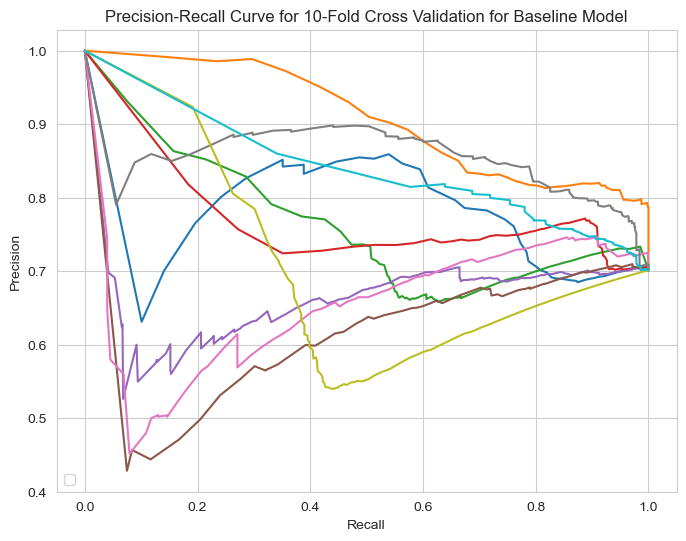

Rocket Model: Mean AP: 0.83, Standard Deviation: 0.02
Baseline Model: Mean AP: 0.76, Standard Deviation: 0.09


In [ ]:
mean_ap, std_ap, mean_ap_b, std_ap_b = lab_trial(num_kernels=50, rocket_transform="rocket", use_multivariate="yes", training_data_df=wifi_first_25p_data,
          training_labels=wifi_first_25p_labels, use_baseline_model=True)

print('Rocket Model: Mean AP: %.2f, Standard Deviation: %.2f' % (mean_ap, std_ap))
print('Baseline Model: Mean AP: %.2f, Standard Deviation: %.2f' % (mean_ap_b, std_ap_b))

#### 50% data

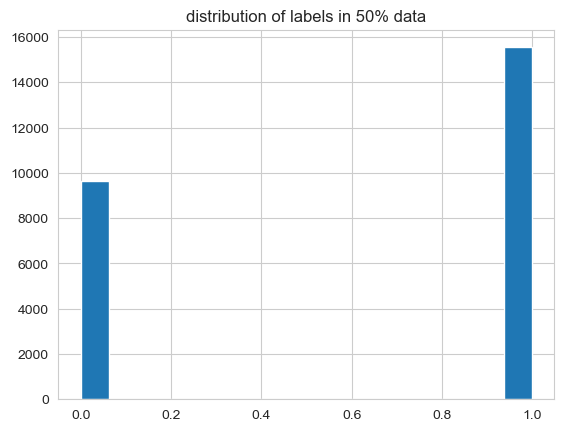

In [ ]:
wifi_first_50p_data = combined_rss_training_df[:len(wifi_y_train) // 2]
wifi_first_50p_labels = wifi_y_train[:len(wifi_y_train) // 2]

hist_from_np_array(wifi_first_50p_labels, "distribution of labels in 50% data")

we see that the ratio is nearly kept so we can move on and train Rocket for this one.

starts training with fold #1


C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core\algorithms.py:1814: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core\algorithms.py:1814: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core\algorithms.py:1814: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core

finished evaluation with fold #1
starts training with fold #2


C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core\algorithms.py:1814: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core\algorithms.py:1814: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core\algorithms.py:1814: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core

finished evaluation with fold #2
starts training with fold #3


C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core\algorithms.py:1814: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core\algorithms.py:1814: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core\algorithms.py:1814: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core

finished evaluation with fold #3
starts training with fold #4


C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core\algorithms.py:1814: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core\algorithms.py:1814: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core\algorithms.py:1814: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core

finished evaluation with fold #4
starts training with fold #5


C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core\algorithms.py:1814: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core\algorithms.py:1814: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core\algorithms.py:1814: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core

finished evaluation with fold #5
starts training with fold #6


C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core\algorithms.py:1814: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core\algorithms.py:1814: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core\algorithms.py:1814: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core

finished evaluation with fold #6
starts training with fold #7


C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core\algorithms.py:1814: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core\algorithms.py:1814: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core\algorithms.py:1814: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core

finished evaluation with fold #7
starts training with fold #8


C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core\algorithms.py:1814: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core\algorithms.py:1814: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core\algorithms.py:1814: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core

finished evaluation with fold #8
starts training with fold #9


C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core\algorithms.py:1814: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core\algorithms.py:1814: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core\algorithms.py:1814: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core

finished evaluation with fold #9
starts training with fold #10


C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core\algorithms.py:1814: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core\algorithms.py:1814: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core\algorithms.py:1814: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core

finished evaluation with fold #10


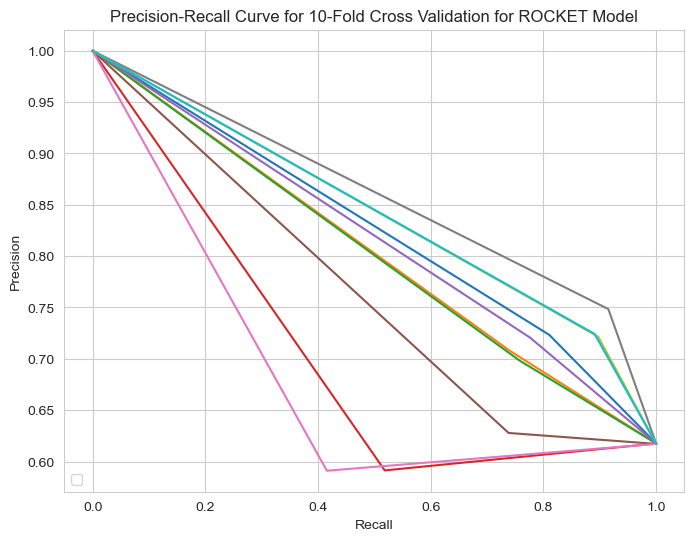

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


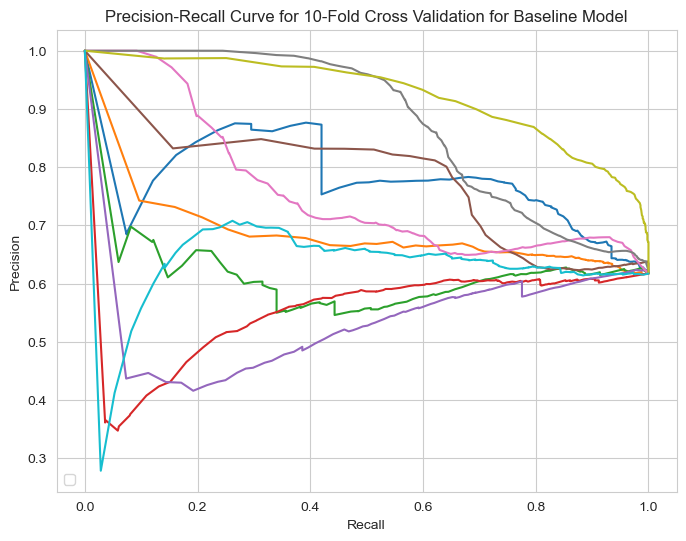

Rocket Model: Mean AP: 0.79, Standard Deviation: 0.06
Baseline Model: Mean AP: 0.72, Standard Deviation: 0.12


In [ ]:
mean_ap, std_ap, mean_ap_b, std_ap_b = lab_trial(num_kernels=50, rocket_transform="rocket", use_multivariate="yes", training_data_df=wifi_first_50p_data,
          training_labels=wifi_first_50p_labels, use_baseline_model=True)

print('Rocket Model: Mean AP: %.2f, Standard Deviation: %.2f' % (mean_ap, std_ap))
print('Baseline Model: Mean AP: %.2f, Standard Deviation: %.2f' % (mean_ap_b, std_ap_b))

#### 75% data

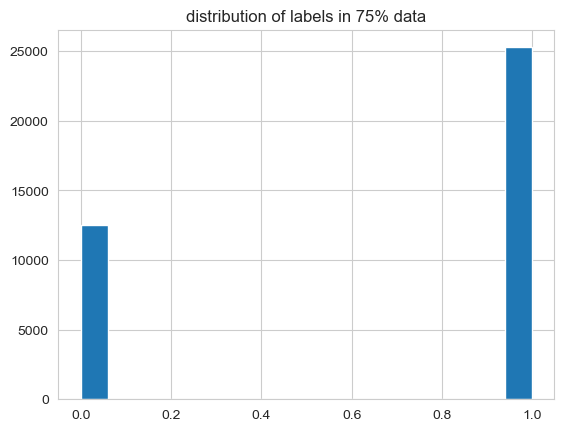

In [ ]:
wifi_first_75p_data = combined_rss_training_df[:len(wifi_y_train) // 4 * 3]
wifi_first_75p_labels = wifi_y_train[:len(wifi_y_train) // 4 * 3]

hist_from_np_array(wifi_first_75p_labels, "distribution of labels in 75% data")

we see that the ratio is nearly kept so we can move on and train Rocket for this one.

starts training with fold #1


C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core\algorithms.py:1814: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core\algorithms.py:1814: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core\algorithms.py:1814: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core

finished evaluation with fold #1
starts training with fold #2


C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core\algorithms.py:1814: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core\algorithms.py:1814: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core\algorithms.py:1814: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core

finished evaluation with fold #2
starts training with fold #3


C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core\algorithms.py:1814: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core\algorithms.py:1814: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core\algorithms.py:1814: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core

finished evaluation with fold #3
starts training with fold #4


C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core\algorithms.py:1814: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core\algorithms.py:1814: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core\algorithms.py:1814: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core

finished evaluation with fold #4
starts training with fold #5


C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core\algorithms.py:1814: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core\algorithms.py:1814: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core\algorithms.py:1814: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core

finished evaluation with fold #5
starts training with fold #6


C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core\algorithms.py:1814: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core\algorithms.py:1814: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core\algorithms.py:1814: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core

finished evaluation with fold #6
starts training with fold #7


C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core\algorithms.py:1814: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core\algorithms.py:1814: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core\algorithms.py:1814: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core

finished evaluation with fold #7
starts training with fold #8


C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core\algorithms.py:1814: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core\algorithms.py:1814: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core\algorithms.py:1814: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core

finished evaluation with fold #8
starts training with fold #9


C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core\algorithms.py:1814: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core\algorithms.py:1814: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core\algorithms.py:1814: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core

finished evaluation with fold #9
starts training with fold #10


C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core\algorithms.py:1814: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core\algorithms.py:1814: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core\algorithms.py:1814: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core

finished evaluation with fold #10


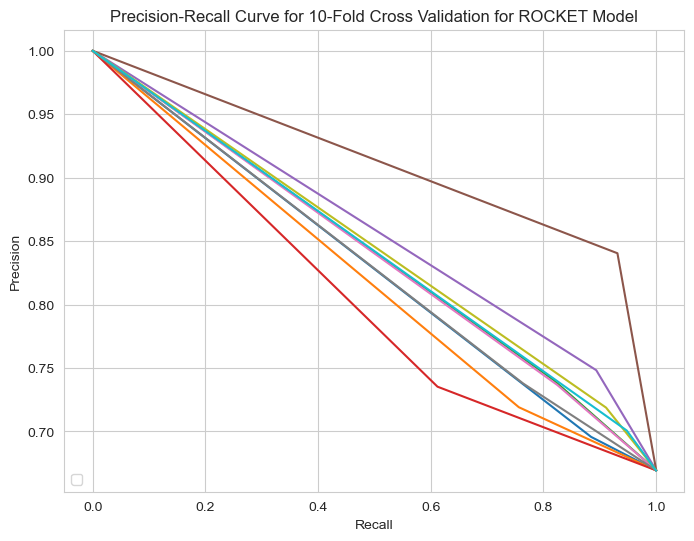

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


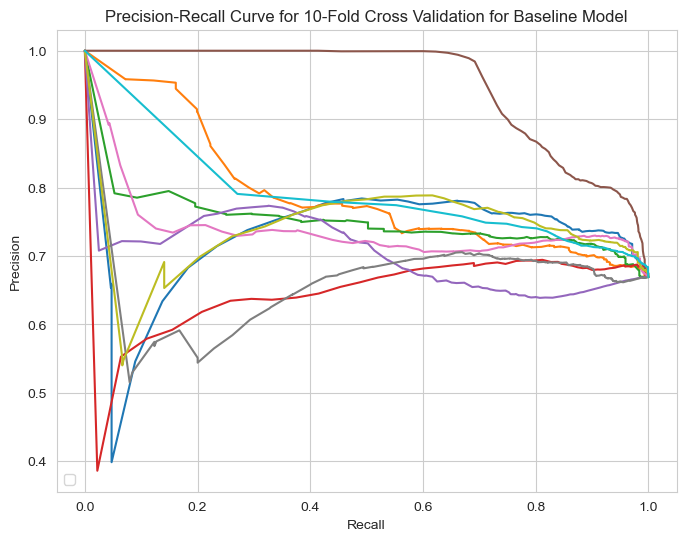

Rocket Model: Mean AP: 0.84, Standard Deviation: 0.03
Baseline Model: Mean AP: 0.75, Standard Deviation: 0.08


In [ ]:
mean_ap, std_ap, mean_ap_b, std_ap_b = lab_trial(num_kernels=50, rocket_transform="rocket", use_multivariate="yes", training_data_df=wifi_first_75p_data,
          training_labels=wifi_first_75p_labels, use_baseline_model=True)

print('Rocket Model: Mean AP: %.2f, Standard Deviation: %.2f' % (mean_ap, std_ap))
print('Baseline Model: Mean AP: %.2f, Standard Deviation: %.2f' % (mean_ap_b, std_ap_b))

#### conclusion
We see that larger data doesn't add much to the results, in fact - it makes it worse! this is probably caused by overfit, as the data includes only 2 variables so the Rocket classifier doesn't have to use a lot of kernels to fit the data,

thus indicating that most data signals could be captured by less data and simpler models, aiming for reaching more data-complex relations in lesser training time.


Hence, we are going to use 25% of data for training the next models for the most of following ablation studies.

### Training different types of Rocket Models
in this section we are going to test several variants of Rocket with several amount of kernels:


*   Rocket
   *     5 kernels
   *     20 kernels
   *     100 kernels (already done in the previous section)
   *     200 kernels
   *     300 kernels
*   MiniRocket (being known as SOTA nowadays)
   *     5 kernels
   *     20 kernels
   *     100 kernels (already done in the previous section)
   *     200 kernels
   *     300 kernels
   *     1000 kernels (see if it leads to overfitting)

also, for some of the models we are going to compare differnet variants of rocket (Base Rocket and MiniRocket), to see the effect of the #kernels vs variants.


starts training with fold #1
finished evaluation with fold #1
starts training with fold #2
finished evaluation with fold #2
starts training with fold #3
finished evaluation with fold #3
starts training with fold #4
finished evaluation with fold #4
starts training with fold #5
finished evaluation with fold #5
starts training with fold #6
finished evaluation with fold #6
starts training with fold #7
finished evaluation with fold #7
starts training with fold #8
finished evaluation with fold #8
starts training with fold #9
finished evaluation with fold #9
starts training with fold #10


finished evaluation with fold #10


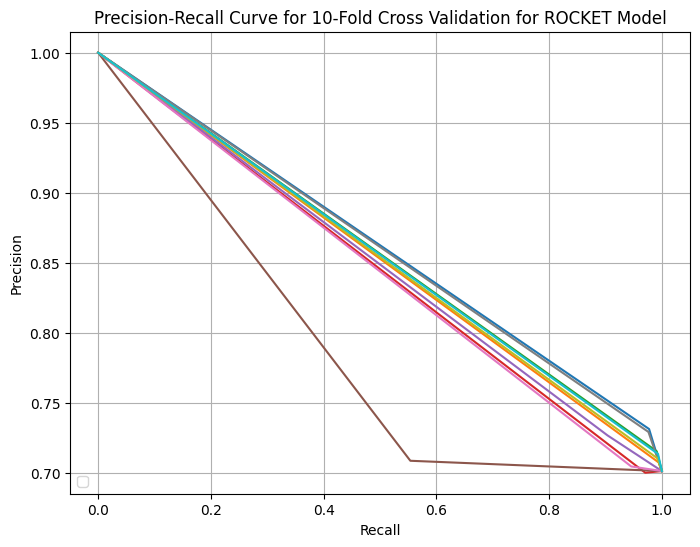

starts training with fold #1
finished evaluation with fold #1
starts training with fold #2
finished evaluation with fold #2
starts training with fold #3
finished evaluation with fold #3
starts training with fold #4
finished evaluation with fold #4
starts training with fold #5
finished evaluation with fold #5
starts training with fold #6
finished evaluation with fold #6
starts training with fold #7
finished evaluation with fold #7
starts training with fold #8
finished evaluation with fold #8
starts training with fold #9
finished evaluation with fold #9
starts training with fold #10


finished evaluation with fold #10


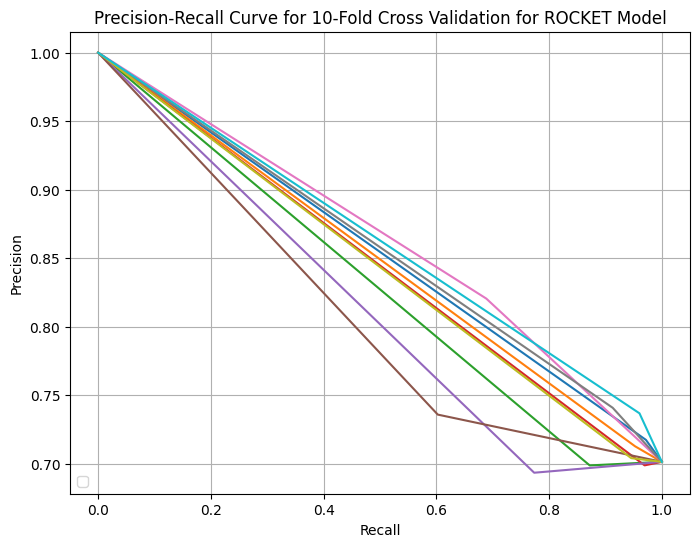

starts training with fold #1
finished evaluation with fold #1
starts training with fold #2
finished evaluation with fold #2
starts training with fold #3
finished evaluation with fold #3
starts training with fold #4
finished evaluation with fold #4
starts training with fold #5
finished evaluation with fold #5
starts training with fold #6
finished evaluation with fold #6
starts training with fold #7
finished evaluation with fold #7
starts training with fold #8
finished evaluation with fold #8
starts training with fold #9
finished evaluation with fold #9
starts training with fold #10


finished evaluation with fold #10


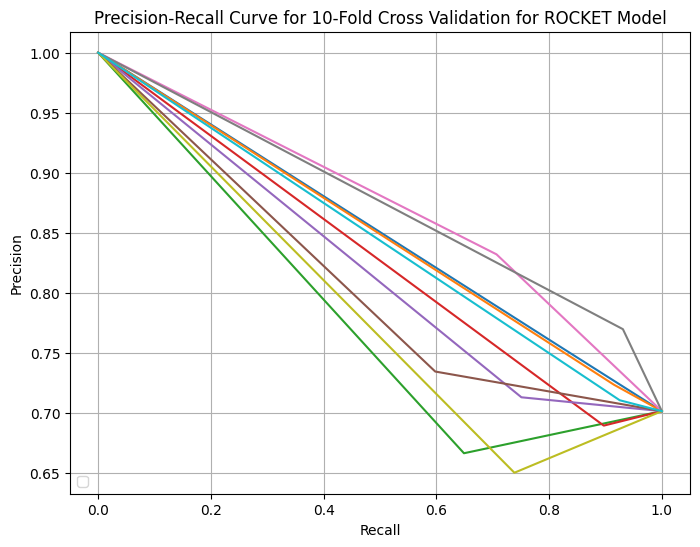

starts training with fold #1
finished evaluation with fold #1
starts training with fold #2
finished evaluation with fold #2
starts training with fold #3
finished evaluation with fold #3
starts training with fold #4
finished evaluation with fold #4
starts training with fold #5
finished evaluation with fold #5
starts training with fold #6
finished evaluation with fold #6
starts training with fold #7
finished evaluation with fold #7
starts training with fold #8
finished evaluation with fold #8
starts training with fold #9
finished evaluation with fold #9
starts training with fold #10


finished evaluation with fold #10


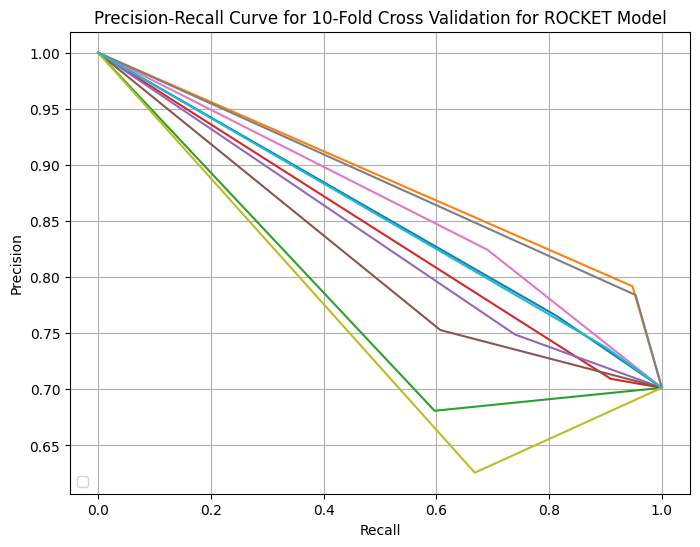

starts training with fold #1
finished evaluation with fold #1
starts training with fold #2
finished evaluation with fold #2
starts training with fold #3
finished evaluation with fold #3
starts training with fold #4
finished evaluation with fold #4
starts training with fold #5
finished evaluation with fold #5
starts training with fold #6
finished evaluation with fold #6
starts training with fold #7
finished evaluation with fold #7
starts training with fold #8
finished evaluation with fold #8
starts training with fold #9
finished evaluation with fold #9
starts training with fold #10


finished evaluation with fold #10


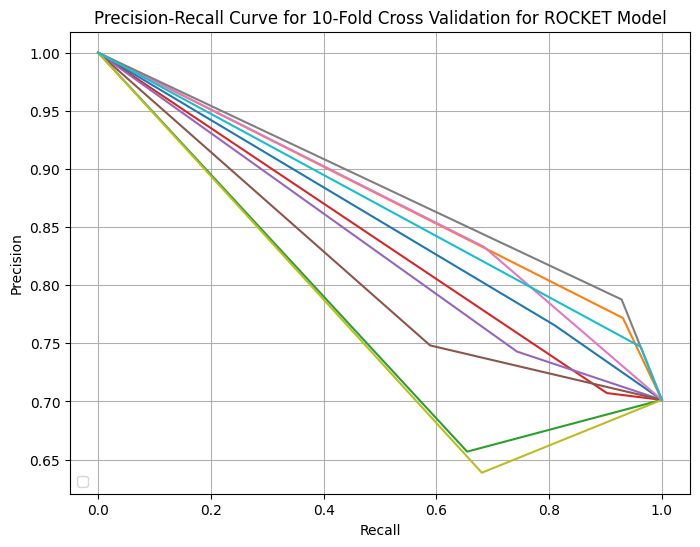

starts training with fold #1
finished evaluation with fold #1
starts training with fold #2
finished evaluation with fold #2
starts training with fold #3
finished evaluation with fold #3
starts training with fold #4
finished evaluation with fold #4
starts training with fold #5
finished evaluation with fold #5
starts training with fold #6
finished evaluation with fold #6
starts training with fold #7
finished evaluation with fold #7
starts training with fold #8
finished evaluation with fold #8
starts training with fold #9
finished evaluation with fold #9
starts training with fold #10


finished evaluation with fold #10


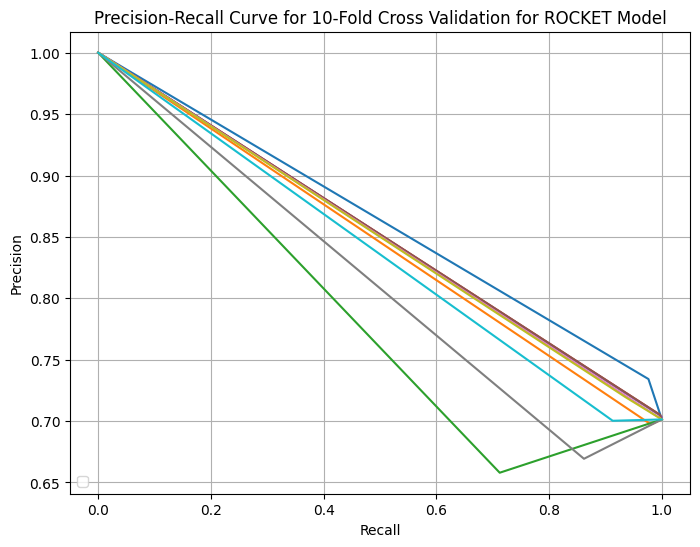

starts training with fold #1
finished evaluation with fold #1
starts training with fold #2
finished evaluation with fold #2
starts training with fold #3
finished evaluation with fold #3
starts training with fold #4
finished evaluation with fold #4
starts training with fold #5
finished evaluation with fold #5
starts training with fold #6
finished evaluation with fold #6
starts training with fold #7
finished evaluation with fold #7
starts training with fold #8
finished evaluation with fold #8
starts training with fold #9
finished evaluation with fold #9
starts training with fold #10


finished evaluation with fold #10


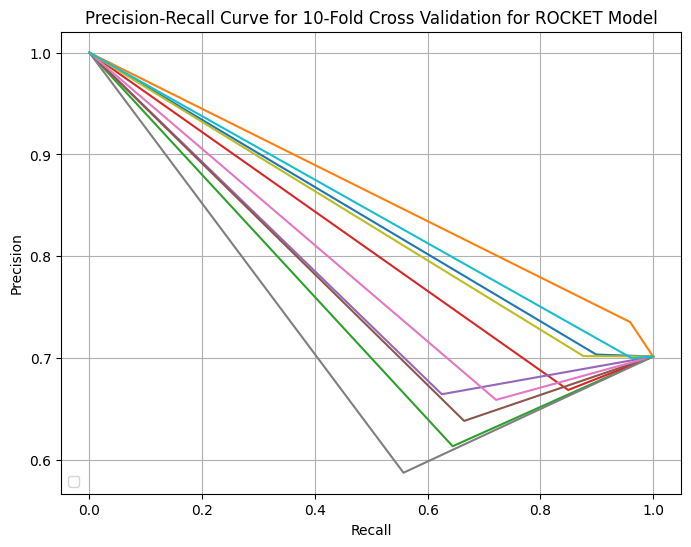

starts training with fold #1
finished evaluation with fold #1
starts training with fold #2
finished evaluation with fold #2
starts training with fold #3
finished evaluation with fold #3
starts training with fold #4
finished evaluation with fold #4
starts training with fold #5
finished evaluation with fold #5
starts training with fold #6
finished evaluation with fold #6
starts training with fold #7
finished evaluation with fold #7
starts training with fold #8
finished evaluation with fold #8
starts training with fold #9
finished evaluation with fold #9
starts training with fold #10


finished evaluation with fold #10


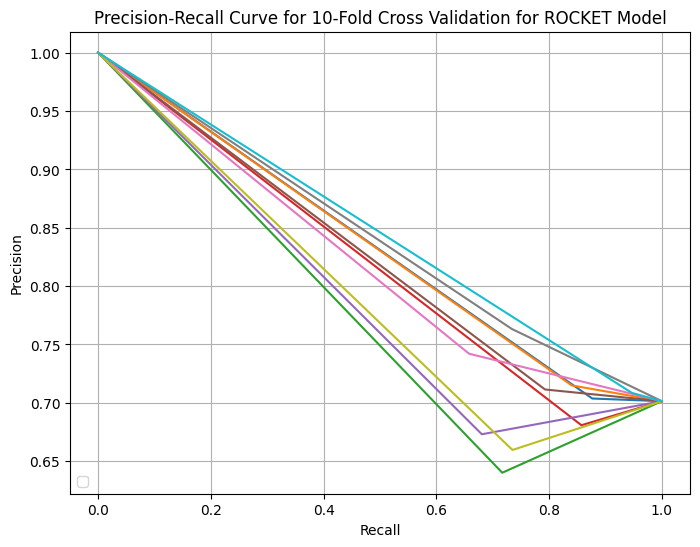

starts training with fold #1
finished evaluation with fold #1
starts training with fold #2
finished evaluation with fold #2
starts training with fold #3
finished evaluation with fold #3
starts training with fold #4
finished evaluation with fold #4
starts training with fold #5
finished evaluation with fold #5
starts training with fold #6
finished evaluation with fold #6
starts training with fold #7
finished evaluation with fold #7
starts training with fold #8
finished evaluation with fold #8
starts training with fold #9
finished evaluation with fold #9
starts training with fold #10


finished evaluation with fold #10


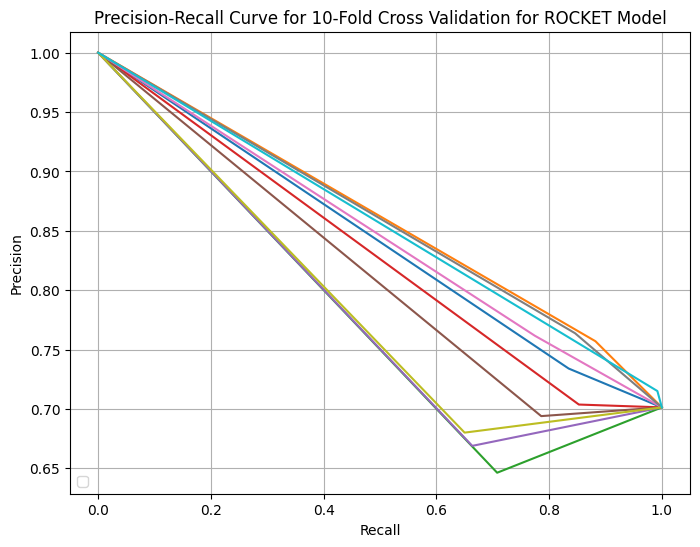

starts training with fold #1
finished evaluation with fold #1
starts training with fold #2
finished evaluation with fold #2
starts training with fold #3
finished evaluation with fold #3
starts training with fold #4
finished evaluation with fold #4
starts training with fold #5
finished evaluation with fold #5
starts training with fold #6
finished evaluation with fold #6
starts training with fold #7
finished evaluation with fold #7
starts training with fold #8
finished evaluation with fold #8
starts training with fold #9
finished evaluation with fold #9
starts training with fold #10


finished evaluation with fold #10


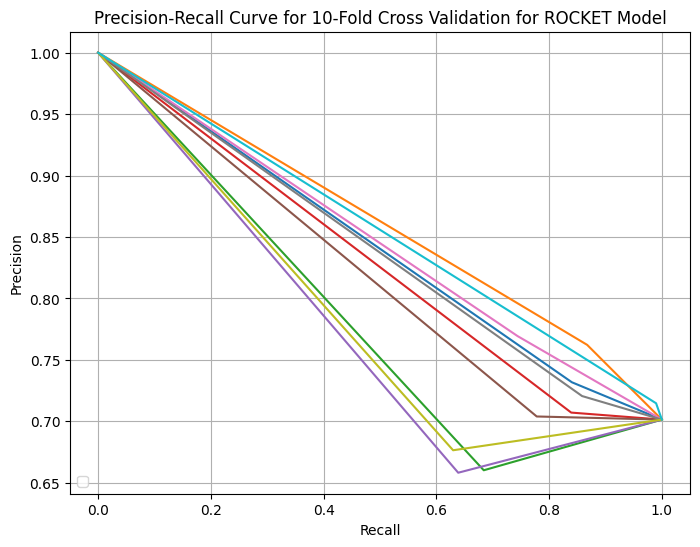

In [ ]:
lab_summarization_columns = ['variant', 'num_kernels', 'is_multivariant?', 'mean_ap', 'std_ap', '%training_data']  # pred&gold labels are saved for future displaying via visualizations

records = []
running_configuration = {
    'rocket': {
        'num_kernels': [5, 20, 100, 200, 300]
    },
    'minirocket': {
        'num_kernels': [100, 200, 300, 1000, 3000]
    }
}

for variant, variant_config in running_configuration.items():
    for kernels in variant_config["num_kernels"]:
        records.append((variant,
                       kernels,
                       "yes",
                      *lab_trial(num_kernels=kernels, rocket_transform=variant, use_multivariate="yes",
                                   training_data_df=wifi_first_25p_data, training_labels=wifi_first_25p_labels),
                        25))

lab_results_df = pd.DataFrame(records, columns=lab_summarization_columns)
lab_results_df.to_csv('rocket_lab_results.csv', index=False)

## Estimating confidence intervals: t-test

we want to estimate the significan of the classifier compared to the the other model which is based upon statistics (Yuval's model).

In order to do so, Let M0 be the "simpler" model. and let M1 be the Rocket-base model. We need to perform a 10-Fold cross-validation and estimate the following:

We are going to use a pairwise comparison
- for the i-th round of 10-fold cross-validation, the same cross partitioning is used to obtain err(M0) and err(M1)
- average over 10 rounds to get:
  
      t = \(mean_err(M0) - mean_err(M1)) / sqrt(var(M0-M1)/k)
- t-test computes t-statistic with k-1 degrees of freedom,
where

      var(M0-M1) = (1/k) * (Σᵢⁿ[err(M0)ᵢ-err(M1)ᵢ - (mean_err(M0)-mean_err(M1))]\^2 )

Let's go then!

In [ ]:
print(1)

1


In [ ]:
complete_dataset_df = pd.concat([combined_rss_training_df, combined_rss_test_df], axis=0)
complete_dataset_as_array = complete_dataset_df.values
complete_labels_df = np.concatenate((wifi_y_train, test_labels), axis=0)

In [ ]:
combined_rss_training_df

,right_rss_values,left_rss_values
0,0 -51.0 1 -51.0 2 -51.0 3 -51....,0 -42.0 1 -42.0 2 -42.0 3 -42....
1,0 -51.0 1 -51.0 2 -51.0 3 -51....,0 -42.0 1 -42.0 2 -42.0 3 -42....
2,0 -51.0 1 -51.0 2 -51.0 3 -51....,0 -42.0 1 -42.0 2 -42.0 3 -42....
3,0 -42.0 1 -42.0 2 -42.0 3 -42....,0 -52.0 1 -52.0 2 -52.0 3 -52....
4,0 -42.0 1 -42.0 2 -42.0 3 -42....,0 -52.0 1 -52.0 2 -52.0 3 -52....
...,...,...
50355,0 -49.0 1 -49.0 2 -49.0 3 -49....,0 -51.0 1 -51.0 2 -51.0 3 -51....
50356,0 -49.0 1 -49.0 2 -49.0 3 -49....,0 -51.0 1 -51.0 2 -51.0 3 -51....
50357,0 -49.0 1 -49.0 2 -49.0 3 -49....,0 -51.0 1 -51.0 2 -51.0 3 -51....
50358,0 -49.0 1 -49.0 2 -49.0 3 -49....,0 -51.0 1 -51.0 2 -51.0 3 -51....


In [ ]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import math

n_splits = 10

null_model_metrics = []
rocket_metrics = []

""" we initialze the model here, to eliminate a chance of random-initialization of
    internal properties in each phase of the train-test folding, thus allowing the
    model to only fit the data of each fold

"""

skf = StratifiedKFold(n_splits=n_splits)

data = combined_rss_training_df
labels = wifi_y_train

for fold, (train_index, test_index) in enumerate(skf.split(data, labels)):
    X_train, X_test = data.iloc[train_index], data.iloc[test_index]
    y_train, y_test = labels[train_index], labels[test_index]

    # Train your model on the training set
    aggregations = [np.std, np.median, np.var, skew, kurtosis]
    null_model = BaselineModel(anomaly_threshold=None, model=RandomForestClassifier(),
                                   aggregations=aggregations)
    rocket = RocketClassifier(num_kernels=100, use_multivariate="yes")
    print(f"starts training with fold #{fold + 1}")
    rocket.fit(X_train, y_train)
    null_model.fit(X_train, y_train, sample_weight='balanced')

    # Make predictions on the test set
    y_pred_rocket = rocket.predict(X_test)
    y_pred_null_model = null_model.predict(X_test)

    # Compute evaluation metric (e.g., RMSE)
    rmse_rocket = np.sqrt(mean_squared_error(y_test, y_pred_rocket))
    rmse_null_model = np.sqrt(mean_squared_error(y_test, y_pred_null_model))

    # Store the evaluation metric
    rocket_metrics.append(rmse_rocket)
    null_model_metrics.append(rmse_null_model)

# Aggregate results
rocket_mean_rmse = np.mean(rocket_metrics)
rocket_std_rmse = np.std(rocket_metrics)

null_model_mean_rmse = np.mean(null_model_metrics)
null_model_std_rmse = np.std(null_model_metrics)

print("Mean RMSE | ROCKET:", rocket_mean_rmse)
print("Standard Deviation RMSE | ROCKET:", rocket_std_rmse)

print("Mean RMSE | NULL:", null_model_mean_rmse)
print("Standard Deviation RMSE | NULL:", null_model_std_rmse)

#now compoute siginificance:
mean_error_diff = rocket_mean_rmse - null_model_mean_rmse
variance_of_model_diff = sum((rmse_null_model - rmse_rocket - (null_model_mean_rmse - rocket_mean_rmse))**2 for rmse_null_model, rmse_rocket in zip(null_model_metrics, rocket_metrics)) / n_splits

t_value = mean_error_diff / (math.sqrt(variance_of_model_diff) / n_splits)

print(f"t-test: t_value = {t_value}")

starts training with fold #1


C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core\algorithms.py:1814: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core\algorithms.py:1814: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core\algorithms.py:1814: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core

starts training with fold #2


C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core\algorithms.py:1814: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core\algorithms.py:1814: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core\algorithms.py:1814: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core

starts training with fold #3


C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core\algorithms.py:1814: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core\algorithms.py:1814: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core\algorithms.py:1814: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core

starts training with fold #4


C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core\algorithms.py:1814: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core\algorithms.py:1814: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core\algorithms.py:1814: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core

starts training with fold #5


C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core\algorithms.py:1814: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core\algorithms.py:1814: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core\algorithms.py:1814: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core

starts training with fold #6


C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core\algorithms.py:1814: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core\algorithms.py:1814: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core\algorithms.py:1814: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core

starts training with fold #7


C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core\algorithms.py:1814: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core\algorithms.py:1814: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core\algorithms.py:1814: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core

starts training with fold #8


C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core\algorithms.py:1814: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core\algorithms.py:1814: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core\algorithms.py:1814: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core

starts training with fold #9


C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core\algorithms.py:1814: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core\algorithms.py:1814: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core\algorithms.py:1814: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core

starts training with fold #10


C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core\algorithms.py:1814: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core\algorithms.py:1814: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core\algorithms.py:1814: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\Yuval\anaconda3\envs\WIFI\Lib\site-packages\pandas\core

Mean RMSE | ROCKET: 0.5246270324278837
Standard Deviation RMSE | ROCKET: 0.061138226369375534
Mean RMSE | NULL: 0.564717254054674
Standard Deviation RMSE | NULL: 0.025950991308899156
t-test: t_value = -6.780582164023048


The metric to be optimized: ap (average precision).

**NOTE**: the reported t-value in the paper was recieved as a mean of 3 runs of the T-test, and it is lower than the one mentioned here (-6.78, of the first trial). We decided to report the lower one as it is more reliable, as a mean of several trials - If considering only the result of the first trial - we get a 99.9% confidence interval (higher than 99% which was reported in the paper)

the underlying assumption here is that the fact we used data from several number of persons occuping the room, we would be able to seperate better the negatives from the positives rather than using only samples where there was exactly one person in the room.

Rocket is known to be the SOTA in time-series classification, so we want to see if handling the data with rocket can lead us to good results.

moreover, they way in which Rocket works is to use *K* random kernels in order to extract a lot of features out of the data in trial to seperate them as best as possible, where the features extracted from the kernels are go through a simple linear layer before prediction.
Therefore, we might have the option to use the resulted features as features to a more-sophisticated model such as SVR or some regression model.



# Summary: trials done in the notebook


we perform a thorough ablation study to examine the impact of variables and parameters on the results of Rocket:

1. the impact of using data of a single antenna vs data from two antennas
2. using differnt portion of the training data, thus allowing us to possibly train larger models in less time
3. using variety of kernel sizes
4. impact of Rocket Variants: Rocket vs MiniRocket

Recall we turned the categorical problem of detecting the **number** of people in the room to a binary classification of occupation, thus all samples containing at least one person in the room turned into positive examples, thus causing imbalance in labels towards positive labels.
Therefore, in all ablation studies we performed a 10-Fold stratified cross-validation with each tested model, which in Rocket's case is crucial as the whole model is based on randomly-generated kernels as the core of its operation, optimizing for roc_auc score (and not accuracy, as for the imbalaned data). In addition, T-tests were also conducted in a 10-fold manner, reporting mean-error over all folds.


First, we examined the impact of using data from both antennas vs from a single antenna. The way we studied it is by training a 100- kernel rocket model on the right antenna's data only, as a baseline, and compared it to a Rocket model trained on data from both antennas.
we performed a t-test and saw that the 2-antennas model performed better, therefore we used both antennas' data for the rest of the experiments.

Next, we performed analyzed the imapct of training data portion. As our problem contains only 2 time-series variables, we suspect that there is no need in large training data as the model is going to overfit the data, and that we could capture the main signals using a smaller model. For that manner we used a 100-kernel Rocket model (as the data is small and contains only 2 variables, we hypotesised that there is no need in more kernels for this analysis) and trained it on 25%, 50% and 75% of data, preserving the original label distribution of the dataset (~2:1 positive-negative labels respectively).
We saw that training on less data yields better results, probably as both variables of the problem are tightly-coupled, thus capturing the relation between them doesn't require large amount of data, and furthermore - it better generalizes on unseen data when trained with less data.

In the 3rd phase of our study, we examined differnt variants of Rocket models: "Rocket" (as the. baseline model) and "MiniRocket" (as the comapct-SOTA version of Rocket), with different amount of kernels, to see the impact of the number of randomly-generated features and the model-variant on the results.
Each variant was trained with several amount of kernels, allowing the MiniRocket to train with more kernels than the Rocket as it is a more time-efficient model, under the assumption that we don't have to use a large amount of kernels - but we want to make sure that training with large number of kernels is not going to surprise us in that manner.
Unsurprisingly, we got that fewer kernels lead to better results, capturing the signals in data while being able to generalize better for unseen data.

This Ablation study resulted in a (( insert here the best model gotten from the lab )), which was tested against the baseline model, we used a (( insert here Yuval's model together with its explanation)) , in order to see which model performs better and yield better results for Wifi-based occupation classification.

Both models were compared using a confidence-interval t-test, using a 10-Fold partition on the training data and then evaluated them on the test data.
 We got that (( insert the best-results model )) performs better (( insert the results of both models )), statistically-significant (( t-test value of comaprison))